# Bayesian Analysis of Math Exam Scores

## Problem Statement

You are provided with a dataset of math exam scores from Estonian primary schools. Your task is to build a Bayesian model to better understand the factors that influence exam performance.

## Data Description

The dataset includes the following variables:
- `year`: The year of the exam (2016-2023), with [2020 missing due to the COVID-19 pandemic](https://www.ohtuleht.ee/998159/pohikooli-eksamid-jaavad-ara-riigieksamid-toimuvad)
- `county`: The county where the student took the exam
- `domestic_background`: Whether the student is Estonian or Russian
- `gender`: Student's gender (Male/Female)
- `avg_grade`: The student's average grade (from 1 to 5, continuous)
- `exam_score`: The exam score (0-50 points)


In [2]:
# Import libraries, import and manipulate 
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('math_exam_scores.csv', sep=";").sample(4000) # Work with a smaller dataset at first so that you don't have to wait 10 minutes every time you sample the model.
#df = pd.read_csv('math_exam_scores.csv', sep=";") 

# DATA MANIPULATIONS #
## YEAR ##
# Convert year to category as there are probably non-linear effects at play
df['year'] = df['year'].astype('category')

# Encode categorical variable 'year' as integers for indexing
df['year'] = df['year'].cat.codes
n_years = df['year'].nunique()

## COUNTY ##
# Make sure county is a category
df['county'] = df['county'].astype('category')

# Encode categorical variable 'county'
df['county'] = df['county'].cat.codes
n_counties = df['county'].nunique()

## GENDER ##
# Convert domestic_background to numerical binary
remap = {'Male': 0, 'Female': 1}
pd.set_option("future.no_silent_downcasting", True)
df['gender'] = df['gender'].replace(remap).values.astype(int)

## DOMESTIC BACKGROUND ##
# Convert domestic_background to numerical binary
remap = {'Estonian': 0, 'Russian': 1}
df['domestic_background'] = df['domestic_background'].replace(remap).values.astype(int)

## CONTINIOUS VARIABLES ##
# Rescaling exam score and since the Beta distribution is the most intuitive choice, then make sure that
#  the rescled exam score is strictly within open interval (0,1), ie. cannot be [0,1].
eps = 1e-6
df['exam_score_rescaled'] = (df['exam_score'] / 50.0).clip(eps, 1-eps)

# Rescaling avg_grade
df['avg_grade_rescaled'] = df['avg_grade'] / 5.0

models = {}

In [3]:
df.describe()

,year,county,domestic_background,gender,exam_score,avg_grade,exam_score_rescaled,avg_grade_rescaled
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.194000,3.964250,0.227250,0.490750,37.243750,3.767653,0.744875,0.753531
std,2.010317,4.735724,0.419108,0.499977,10.476176,0.961138,0.209524,0.192228
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.285823,0.000001,0.057165
25%,1.000000,0.000000,0.000000,0.000000,31.000000,3.172793,0.620000,0.634559
50%,3.000000,2.000000,0.000000,0.000000,40.000000,3.975097,0.800000,0.795019
75%,5.000000,8.000000,0.000000,1.000000,46.000000,4.556862,0.920000,0.911372
max,6.000000,14.000000,1.000000,1.000000,50.000000,4.999508,0.999999,0.999902


## Problem analysis

The DAG that we'll take as the basis of our analysis.

<img src="DAG.png" alt="drawing" width="400"/>

### Justification for the DAG

**Year** - Since this standardised matematics exam is administered to the whole country simultaneously in set year, then all of the possible influencing factors are captured in this factor. Exam exercises are changed every year, so [some years tend to be easier](https://www.err.ee/1609007237/pohikooli-matemaatikaeksami-sooritused-olid-paremad-kui-kahel-eelneval-aastal) and some harder, there are global effects that come into play (eg. COVID-19 pandemic), policy changes, cohort effects etc.<br>
Since all other variables result from a progression of longer processes (eg. county effects on exam score) and any shift in them cannot be attributed to a single year, then Year of the exam does not have influence on other factors.

**County** - Differences in school education quality, population parameters (eg. urban/rural porportions), socio/economic factors are encompassed into the county variable. For that reason county is set to influence academic ability and average grade. <br>
The distribution of Estonian and Russian speaking families is different between counties. Therefore count -> domestic_background. 

**Domestic background** - [PISA statistics](https://harno.ee/sites/default/files/documents/2023-12/Pisa_tulemused_2022_veebi.pdf) show that Estonian and Russian students' academic ability differs quite a lot in Estonia.

**Gender** - [PISA statistics](https://harno.ee/sites/default/files/documents/2023-12/Pisa_tulemused_2022_veebi.pdf) show that there is a gap in academic ability between boys and girls in Estonia.

**Academic ability** - Exam score is meant to measure academic ability of a student, but its an approximation. Its taken as a latent variable into the model. Academic ability is influenced by multiple factors such as school education quality, environment (mediated by county), domestic background and gender etc. <br> 
Average grade also tries to measure academic ability, but has other influencing factors at play (eg. group level effects of school and county, girls tend to worry more about grades than boys). So it cannot be taken as the same kind of measure of academic ability as the exam score.

**Average grade** - Average grade is another attempt at measuring academic ability, but is less standardised. It is also dependent on group level effects from schools and thus counties, ie. a '4' in Harjumaa is likely not the same as a '4' in Võrumaa. Since its a an outcome of academic ability, then it is highly correlated with exam score. <br>
Average grade does however influences **the variability of exam score**, ie. students who have average grade near 5 are probably very good at exams and tests. Knowledge enables them to be faster, thus having more time to overlook the exam submission, finding typos and small mistakes. On the opposite end of the spectrum students who have a very low average grade will probably also struggle on the exam, so its vey unlikely they will suddenly score much points on the exam, therefore variability is also lower.


## Let's model

Table of contents:

**Models with Beta distribution:**
1. [Model with only year (model_beta_m1)](#model_beta_m1)
1. [Model with academic ability and year (model_beta_m2)](#model_beta_m2)
1. [Model with academic ability, average grade and year (model_beta_m3)](#model_beta_m3)
1. [Model with academic ability, average grade and year, $\beta$ is variable (model_beta_m4)](#model_beta_m4)
1. [Model with heteroscedacity 1 (model_beta_heterosc1)](#model_beta_heterosc1)
2. [Model with heteroscedacity 2 (model_beta_heterosc2)](#model_beta_heterosc2)
1. [Full luxury Bayes](#model_beta_luxury)

**Models with Binomial distribution:**
1. [Model with only year (model_binomial_m1)](#model_binomial_m1)
1. [Model with academic ability (model_binomial_m2)](#model_binomial_m2)

## With Beta distribution

Since exam score is bounded within [0,50] and with a hockey stick shape (see graph below), then Scaled Beta distribution is the most suitable option. Later there are some tests with Binomial distribution, but binomial is not ideal in this situation.

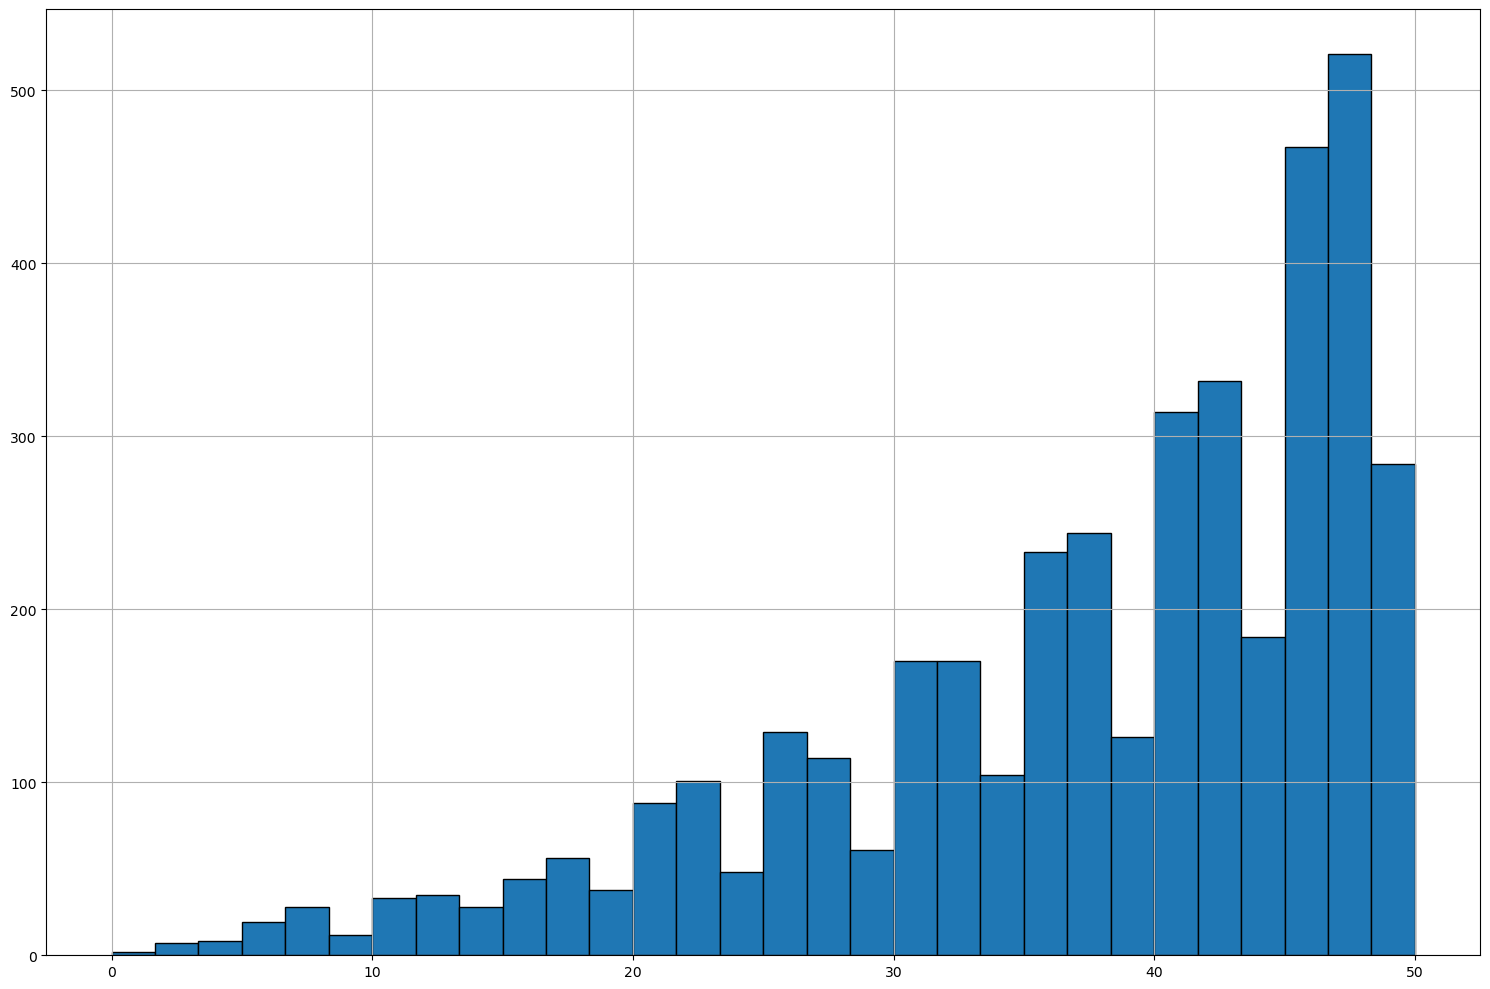

In [6]:
df['exam_score'].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

### <a name="model_beta_m1">Model with only year</a>
First a simple model with just year in the mix. 

In [8]:
with pm.Model() as model_beta_m1:
    # Priors
    intercept = pm.Normal("intercept", mu=1, sigma=1)
    beta_year = pm.Normal("beta_year", mu=1, sigma=1, shape=n_years)

    alpha = intercept + beta_year[df.year]
    
    # Likelihood
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=1, observed=df.exam_score_rescaled)
    
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_m1'] = trace

# Summary
az.summary(trace, round_to=2) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.96,0.36,1.29,2.64,0.02,0.01,402.30,465.20,1.00
beta_year[0],0.39,0.37,-0.30,1.09,0.02,0.01,433.24,503.66,1.00
beta_year[1],-0.22,0.36,-0.86,0.52,0.02,0.01,417.76,513.22,1.00
beta_year[2],1.63,0.38,0.99,2.41,0.02,0.01,464.90,695.12,1.00
beta_year[3],0.12,0.37,-0.55,0.84,0.02,0.01,413.53,543.62,1.00
beta_year[4],2.65,0.40,1.86,3.35,0.02,0.01,489.98,697.18,1.00
beta_year[5],2.70,0.39,1.96,3.41,0.02,0.01,457.16,542.53,1.01
beta_year[6],0.65,0.37,-0.06,1.34,0.02,0.01,414.68,584.46,1.00


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept     1.958  0.358   1.290    2.642      0.018    0.012     402.0   
beta_year[0]  0.386  0.369  -0.299    1.086      0.018    0.011     433.0   
beta_year[1] -0.218  0.363  -0.855    0.518      0.018    0.011     418.0   
beta_year[2]  1.633  0.379   0.986    2.414      0.018    0.011     465.0   
beta_year[3]  0.118  0.366  -0.545    0.838      0.018    0.011     414.0   
beta_year[4]  2.655  0.396   1.860    3.353      0.018    0.011     490.0   
beta_year[5]  2.699  0.392   1.963    3.406      0.018    0.011     457.0   
beta_year[6]  0.654  0.368  -0.063    1.339      0.018    0.012     415.0   

              ess_tail  r_hat  
intercept        465.0   1.00  
beta_year[0]     504.0   1.00  
beta_year[1]     513.0   1.00  
beta_year[2]     695.0   1.00  
beta_year[3]     544.0   1.00  
beta_year[4]     697.0   1.00  
beta_year[5]     543.0   1.01  
beta_year[6]     584.0   1.00  


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_year'}>,
        <Axes: title={'center': 'beta_year'}>]], dtype=object)

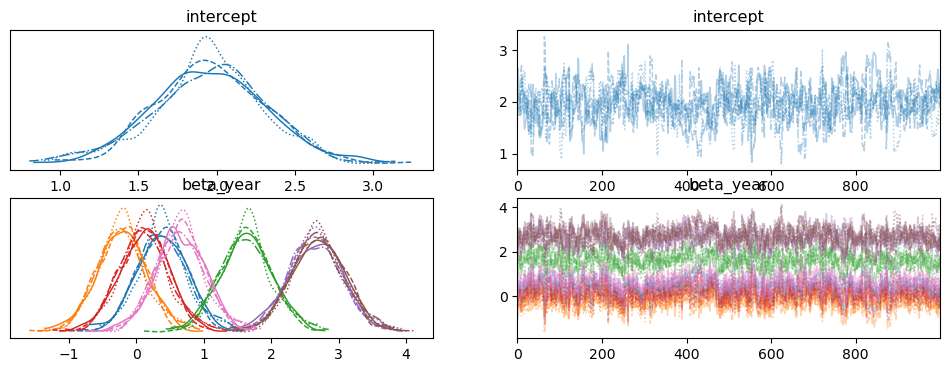

In [9]:
# Model diagnostics
print(pm.summary(trace))
pm.plot_trace(trace)

<Axes: xlabel='y_obs'>

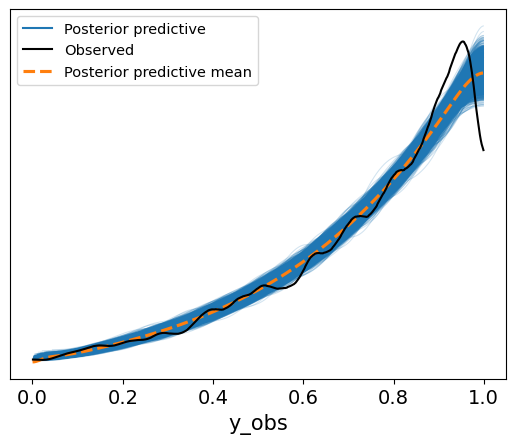

In [10]:
pm.plot_ppc(trace)

### <a name="model_beta_m2">Model with academic ability and year (model_beta_m2)</a>

Model with latent academic ability added to the model.

In [12]:
with pm.Model() as model_beta_m2:
    # Priors
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)

    # Since sigmoid converts into (0,1) interval, but alpha is probably higher so that higher exam score values
    #  would be more prevalent, so the sigmoid is multiplied by 6
    alpha = pm.math.sigmoid(alpha_intercept + beta_academic * academic_ability + beta_year[df.year.values]) * 6
    
    # Likelihood
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=1, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_m2'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability'))]
az.summary(trace, round_to=2, var_names=var_names) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,-0.02,0.44,-0.79,0.81,0.14,0.04,10.10,55.97,1.31
beta_gender,-0.05,0.19,-0.38,0.30,0.03,0.01,47.51,236.68,1.08
beta_domestic,0.03,0.23,-0.41,0.46,0.03,0.01,54.99,274.37,1.06
beta_county[0],0.12,0.39,-0.59,0.83,0.12,0.03,10.03,46.93,1.32
beta_county[1],0.02,0.75,-1.32,1.53,0.04,0.02,408.14,769.84,1.01
beta_county[2],0.36,0.77,-1.22,1.48,0.33,0.16,7.22,30.64,1.57
beta_county[3],-0.18,0.56,-1.24,0.87,0.12,0.02,23.91,117.40,1.12
beta_county[4],0.44,0.98,-1.52,2.08,0.39,0.18,7.77,33.55,1.49
beta_county[5],-0.26,0.63,-1.28,1.02,0.23,0.08,8.88,42.30,1.39
beta_county[6],-0.02,0.56,-1.13,0.99,0.03,0.02,423.74,602.08,1.01


<Axes: xlabel='y_obs'>

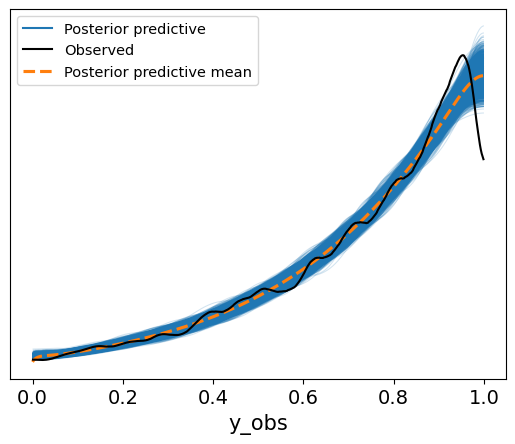

In [13]:
pm.plot_ppc(trace)

### <a name="model_beta_m3">Model with academic ability, average grade and year (model_beta_m3)</a>

Previous model, but average grade is added as a predictor of exam score.

In [15]:
with pm.Model() as model_beta_m3:
    # Priors of the main model
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)

    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_grade = pm.Normal("beta_grade", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)

    # Since sigmoid converts into (0,1) interval, but alpha is probably higher so that higher exam score values
    #  would be more prevalent, so the sigmoid is multiplied by 6
    alpha = pm.math.sigmoid(alpha_intercept + beta_academic*academic_ability + beta_grade*df.avg_grade + beta_year[df.year.values]) * 6
    
    # Likelihood
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=1, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_m3'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability'))]
az.summary(trace, round_to=2, var_names=var_names) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,0.20,0.80,-1.50,1.86,0.28,0.17,8.30,16.33,1.43
beta_gender,0.14,0.58,-0.98,1.17,0.15,0.04,15.98,81.77,1.19
beta_domestic,0.59,1.22,-1.81,2.43,0.52,0.26,6.54,22.07,1.69
beta_county[0],0.63,1.36,-1.87,2.78,0.62,0.28,5.21,32.51,2.16
beta_county[1],-0.02,1.00,-1.89,1.87,0.04,0.02,685.32,1328.12,1.00
beta_county[2],0.23,1.06,-1.65,2.17,0.41,0.19,6.89,13.27,1.57
beta_county[3],-0.00,1.01,-1.85,1.91,0.09,0.04,128.95,362.83,1.05
beta_county[4],0.15,0.98,-1.61,2.02,0.13,0.03,52.92,420.87,1.07
beta_county[5],-0.28,1.10,-2.00,1.95,0.35,0.11,10.56,48.70,1.31
beta_county[6],0.04,1.03,-1.85,2.02,0.08,0.03,171.97,462.68,1.03


<Axes: xlabel='y_obs'>

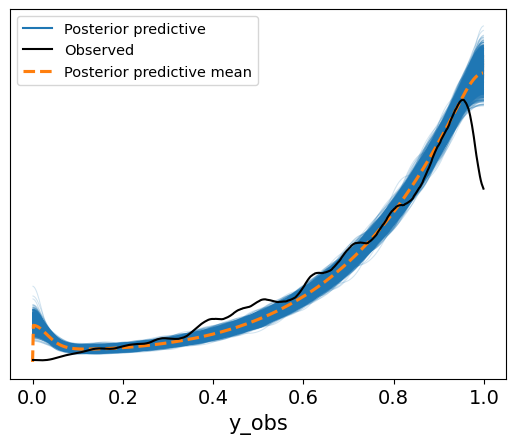

In [16]:
pm.plot_ppc(trace)

## <a name="model_beta_m4">Model with academic ability, average grade and year, $\beta$ is variable (model_beta_m4)</a>

Currently $\beta$ parameter in the Beta distribution is fixed, so let this vary as well.

In [18]:
with pm.Model() as model_beta_m4:    
    # Priors
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_grade = pm.Normal("beta_grade", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)

    alpha = pm.math.sigmoid(alpha_intercept + beta_academic*academic_ability + beta_grade*df.avg_grade + beta_year[df.year.values]) * 6
    beta = pm.Gamma('beta', alpha=2, beta=1)
    
    # Likelihood
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=beta, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_m4'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability'))]
az.summary(trace, round_to=2, var_names=var_names) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,0.28,0.70,-1.00,1.55,0.22,0.07,10.48,35.25,1.32
beta_gender,-0.00,0.48,-1.02,0.80,0.08,0.04,33.22,54.77,1.11
beta_domestic,-0.59,1.08,-2.47,1.50,0.44,0.23,6.81,16.65,1.61
beta_county[0],-0.52,1.12,-2.16,1.82,0.48,0.21,6.34,25.94,1.69
beta_county[1],0.01,1.01,-1.78,2.05,0.04,0.02,629.22,1049.01,1.01
beta_county[2],-0.21,0.88,-1.72,1.58,0.25,0.08,13.31,34.81,1.25
beta_county[3],0.06,1.01,-1.86,1.89,0.08,0.04,142.60,214.79,1.02
beta_county[4],-0.15,0.96,-2.01,1.54,0.09,0.03,125.20,415.40,1.05
beta_county[5],0.32,0.97,-1.34,2.15,0.23,0.05,17.57,164.19,1.16
beta_county[6],0.04,0.94,-1.71,1.83,0.06,0.03,224.36,620.87,1.01


<Axes: xlabel='y_obs'>

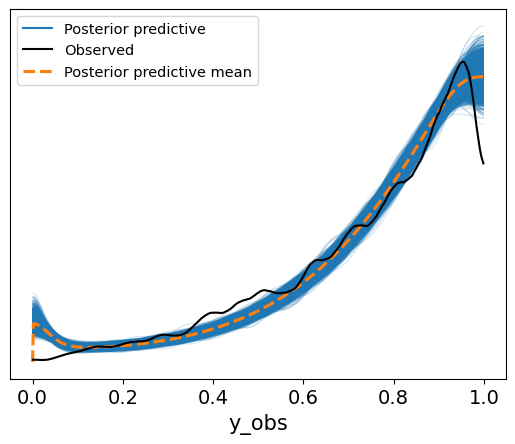

In [19]:
pm.plot_ppc(trace)

## <a name="model_beta_heterosc1">Model with heteroscedacity (model_beta_heterosc1)</a>

Initial data analysis showed that variance of exam score is smaller towards the and point of the scale 0 and 50. See graphs below.

The first attempt is to add some random noise where the variance is dependent on average grade. The second attempt tries to re-parametrize the Beta distribution.

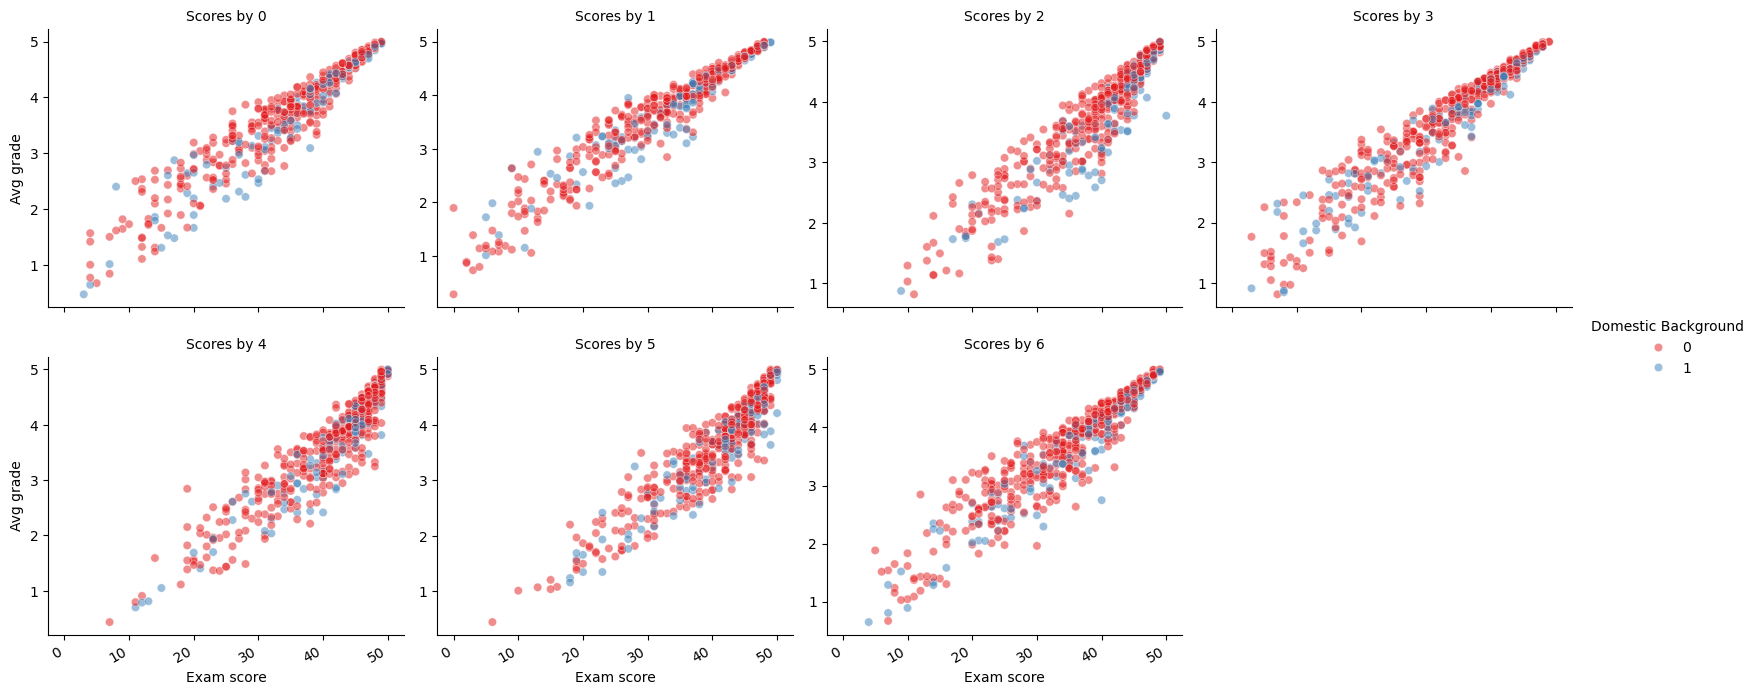

In [21]:
g = sns.FacetGrid(df, col='year', sharey=False, height=4, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="exam_score", y="avg_grade", hue="domestic_background", palette="Set1", alpha=0.5)
g.set_axis_labels("Exam score", "Avg grade")
g.set_titles("Scores by {col_name}")
g.fig.autofmt_xdate()
g.add_legend(title="Domestic Background")
plt.show()

In [22]:
with pm.Model() as model_beta_heterosc1:    
    # Priors
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_grade = pm.Normal("beta_grade", mu=0, sigma=1)
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    
    # Latent variable: academic ability
    academic_ability = pm.Deterministic("academic_ability", 
        acad_intercept
        + beta_county[df.county]  # county effect
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background)

    alpha = pm.math.sigmoid(alpha_intercept + beta_academic*academic_ability + beta_year[df.year.values]) * 6
    beta = pm.Gamma('beta', alpha=2, beta=1)
    sigma = (df.avg_grade_rescaled*(1-df.avg_grade_rescaled))

    # A 0-centered random noise is added to each observation with variability 0 when average grade is near 0 or 5.
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=beta, observed=df.exam_score_rescaled) + pm.Normal("heteroscedacity_component", mu=0, sigma=sigma)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_heterosc1'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if (not(c.startswith('academic_ability') or c.startswith('heteroscedacity_component')))]
az.summary(trace, round_to=2, var_names=var_names) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,0.02,0.99,-1.78,1.93,0.01,0.02,9128.83,2702.64,1.00
beta_gender,0.04,0.44,-0.90,0.80,0.05,0.01,68.43,2167.19,1.04
beta_domestic,-0.10,0.63,-1.29,1.11,0.14,0.01,20.35,155.80,1.12
beta_county[0],-0.12,0.68,-1.33,1.18,0.18,0.02,14.98,165.02,1.18
beta_county[1],-0.01,0.96,-1.83,1.70,0.01,0.02,9953.33,2404.65,1.00
beta_county[2],-0.32,1.38,-2.34,2.27,0.46,0.10,11.16,114.02,1.26
beta_county[3],0.11,0.88,-1.52,1.75,0.14,0.01,37.16,1101.38,1.07
beta_county[4],-0.21,1.22,-2.19,2.24,0.33,0.04,14.52,113.63,1.19
beta_county[5],0.18,0.98,-1.64,1.95,0.26,0.04,15.20,109.30,1.18
beta_county[6],0.01,0.83,-1.48,1.64,0.01,0.02,8553.73,2597.37,1.00


<Axes: xlabel='y_obs'>

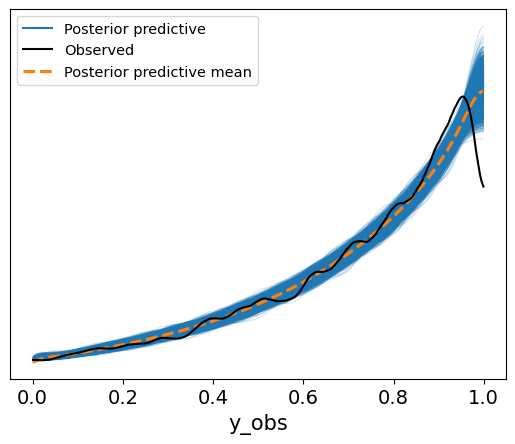

In [23]:
pm.plot_ppc(trace)

In [24]:
with pm.Model() as model_beta_heterosc2:    
    # Priors to modeling academic_ability
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    academic_ability = pm.Deterministic("academic_ability", 
        acad_intercept
        + beta_county[df.county]  # county effect
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background)

    # Priors to modeling exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)

    # Based on https://distribution-explorer.github.io/continuous/beta.html trying to reparametrize with phi and kappa 
    # Where phi is the mean and kappa is variance
    phi = pm.math.sigmoid(alpha_intercept + beta_academic*academic_ability + beta_year[df.year])
    kappa = pm.Exponential("kappa", df.avg_grade_rescaled*(1- df.avg_grade_rescaled))
    
    y_obs = pm.Beta("y_obs", alpha=phi*kappa, beta=(1-phi)*kappa, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_heterosc2'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability') or c.startswith('heteroscedacity_component'))]
az.summary(trace, round_to=2, var_names=var_names) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,-0.08,1.02,-1.92,1.85,0.02,0.02,2704.59,2763.48,1.01
beta_gender,0.25,0.52,-0.83,1.09,0.22,0.10,7.30,30.03,1.51
beta_domestic,-0.06,0.37,-0.78,0.59,0.06,0.01,40.26,744.12,1.07
beta_county[0],-0.42,0.84,-1.68,1.27,0.37,0.18,7.25,31.65,1.52
beta_county[1],0.09,0.91,-1.66,1.78,0.06,0.02,224.42,2337.70,1.02
...,...,...,...,...,...,...,...,...,...
kappa[3995],12.74,10.16,0.22,31.06,0.13,0.24,5733.87,2325.53,1.00
kappa[3996],5.60,4.30,0.08,13.08,0.05,0.11,8502.43,2654.23,1.00
kappa[3997],8.37,6.76,0.07,20.44,0.08,0.16,6811.55,2426.41,1.00
kappa[3998],5.95,4.74,0.20,14.60,0.05,0.12,7240.51,2133.11,1.00


<Axes: xlabel='y_obs'>

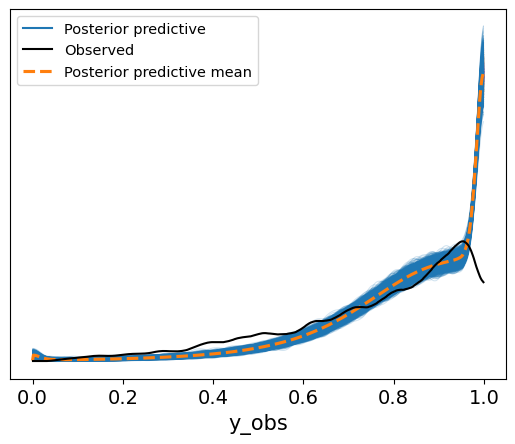

In [25]:
pm.plot_ppc(trace)

## Full luxury Bayes (model_beta_luxury) <a name="model_beta_luxury"></a>

Let's model the full luxury Bayes model where everything is modelled like the DAG implies.

In [27]:
with pm.Model() as model_beta_luxury:  
    # Domestic background
    db_intercept = pm.Normal("db_intercept", mu=0, sigma=1)
    db_beta_county = pm.Normal("db_beta_county", mu=0, sigma=1, shape=n_counties)
    db_logit_p = db_intercept + db_beta_county[df.county]
    domestic = pm.Bernoulli("domestic", logit_p=db_logit_p, observed=df.domestic_background)

    # Priors for academic ability
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    acad_beta_gender = pm.Normal("acad_beta_gender", mu=0, sigma=1)
    acad_beta_domestic = pm.Normal("acad_beta_domestic", mu=0, sigma=1)
    acad_beta_county = pm.Normal("acad_beta_county", mu=0, sigma=1, shape=n_counties)

    # Latent variable: academic ability
    mu = (acad_intercept
        + acad_beta_gender * df.gender
        + acad_beta_domestic * domestic
        + acad_beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)
    
    # Average grade
    ag_intercept = pm.Normal("ag_intercept", mu=0, sigma=1)
    ag_beta_gender = pm.Normal("ag_beta_gender", mu=0, sigma=1)
    ag_beta_academic = pm.Normal("ag_beta_academic", mu=0, sigma=1)
    ag_beta_county = pm.Normal("ag_beta_county", mu=0, sigma=1, shape=n_counties)
    #ag_beta = pm.Gamma('ag_beta', alpha=2, beta=1)
    
    ag_alpha = pm.math.sigmoid(ag_intercept + ag_beta_gender*df.gender + ag_beta_academic*academic_ability + ag_beta_county[df.county]) * 6
    
    grade = pm.Beta("grade", alpha=ag_alpha, beta=1, observed=df.avg_grade_rescaled)    

    # Priors for calculating exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_year = pm.Normal("acad_beta_year", mu=0, sigma=1, shape=n_years)
    
    # Alpha and beta for Beta distribution
    alpha = pm.math.sigmoid(alpha_intercept + beta_academic*academic_ability + beta_year[df.year]) * 6
    beta = pm.Gamma('beta', alpha=2, beta=1)
    sigma = (grade*(1-grade))

    # Likelihood
    # Heteroscedacity - A 0-centered random noise is added to each observation with variability 0 when average grade is near 0 or 5.
    y_obs = pm.Beta("y_obs", alpha=alpha, beta=1, observed=df.exam_score_rescaled) + pm.Normal("heteroscedacity_component", mu=0, sigma=sigma)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_luxury'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability') or c.startswith('heteroscedacity_component'))]
az.summary(trace, round_to=2, var_names=var_names) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
db_intercept,-2.53,0.27,-3.00,-1.99,0.01,0.01,745.62,1251.95,1.00
db_beta_county[0],1.55,0.27,1.03,2.07,0.01,0.01,767.76,1353.12,1.00
db_beta_county[1],-0.40,0.69,-1.66,0.91,0.01,0.01,5319.01,2762.22,1.00
db_beta_county[2],3.47,0.29,2.93,4.01,0.01,0.01,800.28,1505.14,1.00
db_beta_county[3],-1.31,0.60,-2.43,-0.21,0.01,0.01,3609.06,2726.91,1.00
...,...,...,...,...,...,...,...,...,...
acad_beta_year[3],-0.62,0.38,-1.34,0.08,0.04,0.01,90.75,729.93,1.04
acad_beta_year[4],1.01,0.39,0.28,1.73,0.03,0.01,132.13,955.23,1.04
acad_beta_year[5],1.03,0.40,0.29,1.76,0.04,0.01,119.14,1048.73,1.04
acad_beta_year[6],-0.21,0.38,-0.90,0.52,0.04,0.01,105.57,978.87,1.04


array([<Axes: xlabel='domestic'>, <Axes: xlabel='grade'>,
       <Axes: xlabel='y_obs'>], dtype=object)

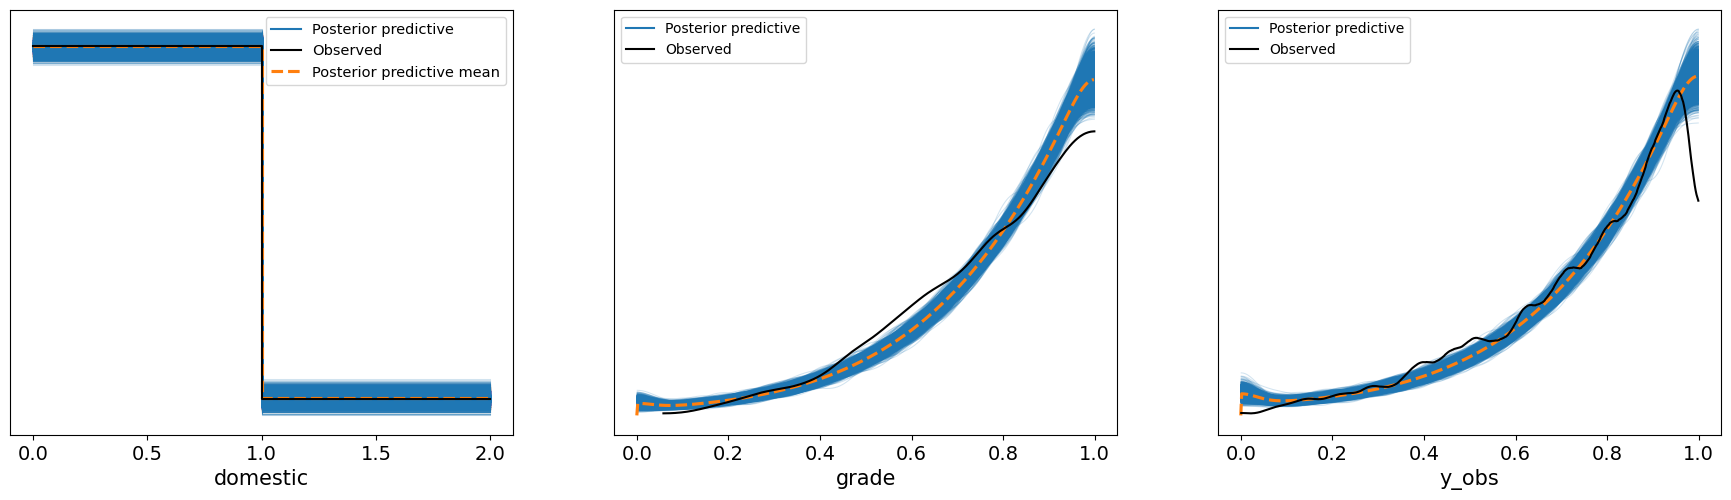

In [28]:
pm.plot_ppc(trace)

## With Binomial distribution

In [30]:
# Binomial model with year
with pm.Model() as model_binomial_m1:
    # Priors
    intercept = pm.Normal("intercept", mu=1, sigma=1)
    beta_year = pm.Normal("beta_year", mu=1, sigma=1, shape=n_years)

    # Logistic regression model
    logit_p = intercept + beta_year[df.year]
    
    # Likelihood
    y_obs = pm.Binomial("y_obs", n=50, logit_p=logit_p, observed=df.exam_score)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_binomial_m1'] = trace

# Summary
az.summary(trace, round_to=2) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.21,0.35,-0.38,0.91,0.03,0.02,171.66,222.39,1.03
beta_year[0],0.65,0.35,-0.03,1.25,0.03,0.02,171.87,229.64,1.03
beta_year[1],0.41,0.35,-0.31,0.98,0.03,0.02,171.48,224.09,1.03
beta_year[2],1.08,0.35,0.37,1.66,0.03,0.02,172.43,224.99,1.03
beta_year[3],0.50,0.35,-0.19,1.10,0.03,0.02,172.06,222.94,1.03
beta_year[4],1.38,0.35,0.64,1.94,0.03,0.02,171.73,228.33,1.03
beta_year[5],1.37,0.35,0.68,1.96,0.03,0.02,171.73,231.00,1.03
beta_year[6],0.74,0.35,0.05,1.34,0.03,0.02,171.73,231.75,1.03


<Axes: xlabel='y_obs'>

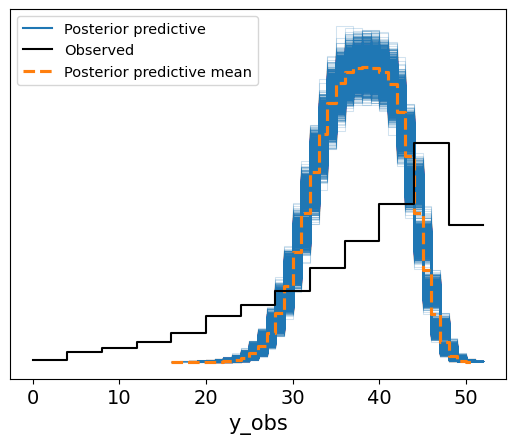

In [31]:
pm.plot_ppc(trace)

In [32]:
# Binomial model with year and academic ability
with pm.Model() as model_binomial_m2:
    # Priors for academic ability
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
        
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    
    # Logistic regression model
    logit_p = alpha_intercept + beta_academic * academic_ability + beta_year[df.year.values]
    
    # Likelihood
    y_obs = pm.Binomial("y_obs", n=50, logit_p=logit_p, observed=df.exam_score)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_binomial_m2'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability') or c.startswith('heteroscedacity_component'))]
az.summary(trace, round_to=2, var_names=var_names) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,-0.54,0.66,-1.52,0.62,0.30,0.08,5.48,37.83,1.97
beta_gender,0.02,0.05,-0.07,0.10,0.02,0.01,8.60,30.32,1.38
beta_domestic,-0.01,0.05,-0.09,0.08,0.01,0.00,61.41,2092.07,1.04
beta_county[0],-0.08,0.26,-0.60,0.40,0.04,0.01,43.13,500.99,1.08
beta_county[1],-0.00,0.33,-0.61,0.63,0.02,0.01,315.05,1210.38,1.02
beta_county[2],-0.12,0.29,-0.67,0.46,0.08,0.01,15.53,53.53,1.19
beta_county[3],0.04,0.30,-0.51,0.60,0.06,0.01,24.02,132.61,1.12
beta_county[4],-0.17,0.37,-0.86,0.54,0.13,0.05,9.26,31.31,1.36
beta_county[5],0.06,0.30,-0.49,0.62,0.07,0.01,18.23,83.13,1.16
beta_county[6],0.01,0.28,-0.54,0.53,0.01,0.01,503.80,977.90,1.02


<Axes: xlabel='y_obs'>

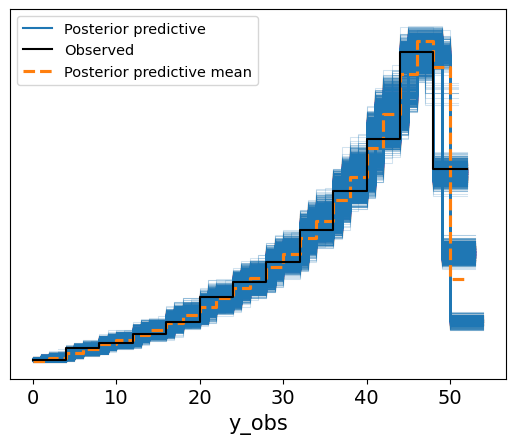

In [33]:
pm.plot_ppc(trace)

## Truncated normal

In [35]:
with pm.Model() as model_trun_normal_m1:    
    # Priors
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_grade = pm.Normal("beta_grade", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)

    mu = alpha_intercept + beta_academic*academic_ability + beta_year[df.year.values]
    sigma = beta_grade*(df.avg_grade*(5-df.avg_grade))
    
    # Likelihood
    y_obs = pm.TruncatedNormal("y_obs", mu=mu, sigma=sigma, lower=0, upper=50, observed=df.exam_score)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_trun_normal_m1'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability'))]
az.summary(trace, round_to=2, var_names=var_names) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,-5.04,8.71,-11.88,11.27,4.32,2.50,4.59,13.32,2.91
beta_gender,-0.01,0.10,-0.21,0.17,0.01,0.00,73.20,517.61,1.07
beta_domestic,-0.09,0.21,-0.41,0.35,0.08,0.03,7.79,37.94,1.49
beta_county[0],-0.52,0.90,-1.54,1.26,0.43,0.24,6.72,30.33,1.61
beta_county[1],-0.24,0.72,-1.55,1.15,0.22,0.07,10.92,35.90,1.29
beta_county[2],-0.58,1.04,-1.75,1.50,0.49,0.27,6.88,37.72,1.60
beta_county[3],-0.19,0.52,-1.11,0.84,0.17,0.05,10.31,43.01,1.34
beta_county[4],-0.65,1.19,-2.05,1.74,0.56,0.30,7.09,38.95,1.56
beta_county[5],-0.21,0.46,-1.01,0.70,0.17,0.06,8.32,30.13,1.42
beta_county[6],-0.49,0.92,-1.76,1.36,0.40,0.19,7.36,36.02,1.54


<Axes: xlabel='y_obs'>

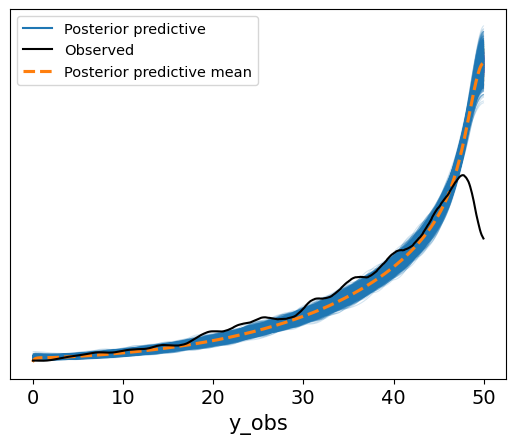

In [36]:
pm.plot_ppc(trace)

In [66]:
with pm.Model() as model_trun_normal_m2:    
    # Priors
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors for exam score
    alpha_intercept = pm.Normal("alpha_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_grade = pm.Normal("beta_grade", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)

    mu = alpha_intercept + beta_academic*academic_ability + beta_year[df.year.values]
    #sigma = beta_grade*(df.avg_grade*(5-df.avg_grade))
    
    # Likelihood
    y_obs = pm.TruncatedNormal("y_obs", mu=mu, sigma=10, lower=0, upper=50, observed=df.exam_score)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_trun_normal_m2'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability'))]
az.summary(trace, round_to=2, var_names=var_names) 

Computing ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,-3.73,0.28,-4.26,-3.21,0.02,0.01,182.92,466.57,1.03
beta_gender,0.05,0.05,-0.05,0.14,0.00,0.00,2133.52,2639.89,1.00
beta_domestic,-0.02,0.07,-0.15,0.11,0.00,0.00,1805.46,2853.06,1.00
beta_county[0],-0.39,0.26,-0.84,0.13,0.01,0.01,393.45,864.01,1.01
beta_county[1],-0.15,0.39,-0.88,0.57,0.01,0.01,964.63,1687.62,1.00
beta_county[2],-0.50,0.27,-1.02,-0.01,0.01,0.01,426.83,896.66,1.01
beta_county[3],-0.02,0.30,-0.59,0.52,0.01,0.01,485.29,1038.43,1.01
beta_county[4],-0.71,0.31,-1.31,-0.14,0.01,0.01,513.66,1327.36,1.00
beta_county[5],-0.01,0.28,-0.51,0.53,0.01,0.01,411.47,1081.56,1.01
beta_county[6],-0.14,0.32,-0.74,0.48,0.01,0.01,536.68,1201.72,1.01


## Model comparison

/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if

                      rank      elpd_loo        p_loo     elpd_diff  \
model_beta_m4            0   2934.061124     5.428122      0.000000   
model_beta_m3            1   2922.227324     3.169892     11.833800   
model_beta_luxury        2   2187.588527   280.566283    746.472598   
model_beta_m2            3   1788.438600   168.754943   1145.622524   
model_beta_heterosc1     4   1777.319432    21.210285   1156.741692   
model_beta_m1            5   1766.188381     9.787062   1167.872743   
model_beta_heterosc2     6   1062.798846  1212.061894   1871.262278   
model_binomial_m2        7 -11575.562449  2922.112594  14509.623573   
model_trun_normal_m1     8 -12275.403493   265.556931  15209.464617   
model_trun_normal_m2     9 -13827.344044  1383.131101  16761.405168   
model_binomial_m1       10 -28409.938326    72.576329  31343.999450   

                            weight          se         dse  warning scale  
model_beta_m4         9.699014e-01   35.989245    0.000000    False   l

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

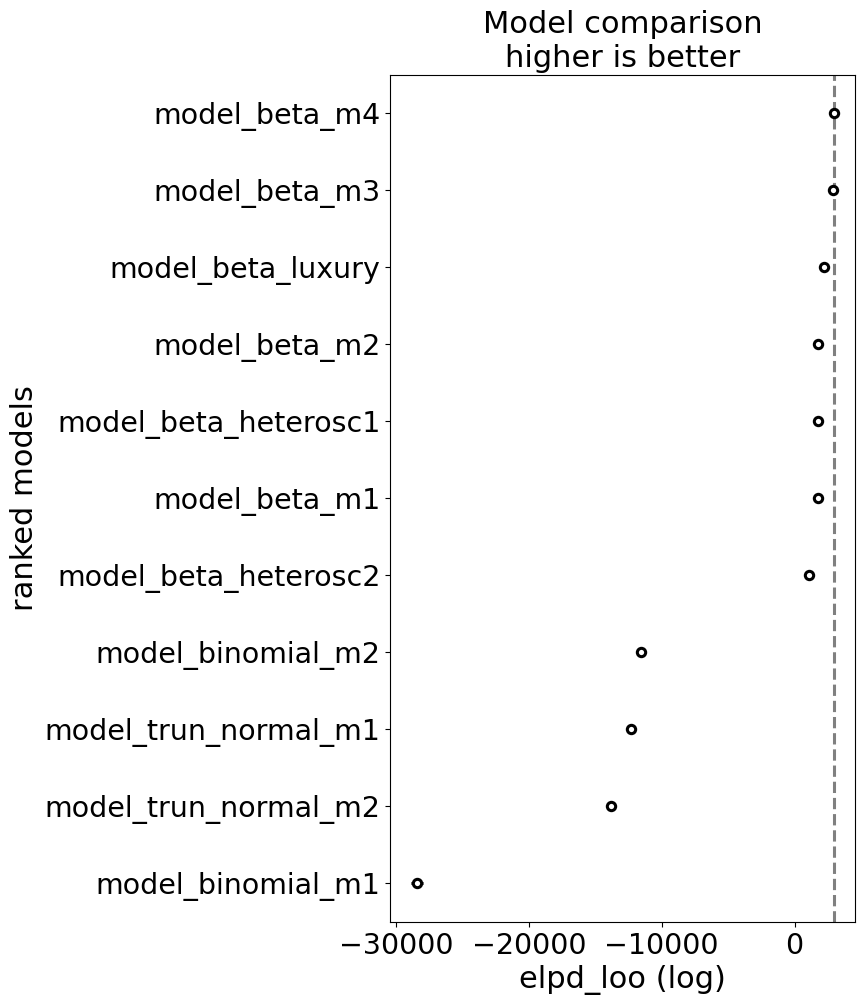

In [68]:
comp = az.compare(models, var_name='y_obs')
print(comp)
az.plot_compare(comp)